# Conway's *Game of Life* with a Convolutional Neural Network (CNN)


Here we build a CNN that can be used to calculate iterations in Conway's *Game of Life*. This allows iterations to be calculated using only mathematical operations, without a need for the logical if-statements that are embedded in the game's rules.

## Conway's *Game of Life*
As is explained in the Wikipedia article, [Conway's *Game of Life*](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) is a cellular automaton devised by the British mathematician John Conway in 1970. The game takes place on a 2-dimensional grid of cells, where each cell can be either dead or alive.

After the cells in a grid are given an initial value (called a *seed*), the state of each cell of the grid in a subsequent time step (called a *tick*) is defined according to the following rules:
0. Any live cell with fewer than two live neighbors dies, as if caused by underpopulation.
0. Any live cell with two or three live neighbors lives on to the next generation.
0. Any live cell with more than three live neighbors dies, as if by overpopulation.
0. Any dead cell with exactly three live neighbors becomes a live cell, as if by reproduction.

## Why CNNs?
CNNs are typically used for image processing. A CNN is a type of neural network that includes at least one convolutional layer. In a convolutional layer, a convolutional filter is applied to the input (e.g. a 2-dimensional image). The filter can be thought of as a window that slides over the input, each time computing the same function on the pixels covered by the window, resulting in a singular value for each window position. Typically the value is the summation of the elementwise multiplication of the filter and the covered pixels (potentially adding a bias term), to which a (potentially non-linear) activation function can then be applied.

Since a rule-based calculation of the next iteration in a game of life also (implicitly) requires a sort of sliding window to go over the field (since for each cell all of its neighbours have to be inspected), I thought it would be an interesting exercise to see if a CNN might be employed to implement the same function, how compact such a CNN could be, and if its weights would provide any insight into the computation.

## Implementation
### Importing packages
First we import some necessary packages. We use [NumPy](http://www.numpy.org/) to represent a grid data structure and [Keras](https://keras.io/) for implementing the CNN.

In [1]:
# display the version of Python
!python --version

# import Numpy and show its version
import numpy as np
print('Numpy version', np.version.version)

# import Keras and show its version and backend
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding2D
print('Keras version {} using "{}" backend'.format(keras.__version__, keras.backend.backend()))

# import timing functionality
import time

Python 3.5.2
Numpy version 1.14.2
Keras version 2.1.5 using "tensorflow" backend


### Conway's *Game of Life* functionality
Next we implement some functionality for Conway's *Game of Life*, for typical actions like creating and seeding a grid, and computing an iteration.

In [2]:
class ConwaysGameOfLife:
    """Implement functionality for Conway's Game of Life, such as creating
    and seeding a grid, and computing an iteration of the grid.
    The grid is modelled as a NumPy matrix of data-type `int`.
    """

    @staticmethod
    def next_iteration_value(block):
        """Take a block of 9 cells (a center cell along with its neighbours)
        and compute the next value of the center cell. Returns an int.
        """
        a = block.ravel()
        center_cell = a[4]
        neighbours = np.sum(a) - center_cell
        if center_cell:
            # (1) a live cell with fewer than two neighbours dies
            #     (= underpopulation)
            # (2) live cell with two or three neighbours lives on
            # (3) a live cell with more than three neighbours dies
            #     (= overpopulation)
            return int(neighbours == 2 or neighbours == 3)
        else:
            # (4) a dead cell with exactly three neighbours comes alive
            #     (= reproduction)
            return int(neighbours == 3)
    
    @staticmethod
    def draw(grid):
        """Draw a string representation of a grid."""
        lines = ['|' + ('-' * grid.shape[1]) + '|']
        for row in grid:
            lines.append(
                '|' + ''.join(('█' if x else '░' for x in row)) + '|'
                )
        lines.append(lines[0])
        return '\n'.join(lines)
    
    def __repr__(self):
        """Draw a string representation of the grid."""
        return ConwaysGameOfLife.draw(self.grid)
    
    def __init__(self, width, height, probability_for_life=0.67):
        """Create a grid of the requested dimensions and randomly seed
        it, using the given probability for a cell to be live.
        """
        self.width = width
        self.height = height
        self.grid = (
            np.random.random_sample((height, width)) > probability_for_life
            ).astype(int)
    
    def iterate(self):
        """Compute the next iteration of a playing field."""
        # initialize the result (as an empty grid)
        result = np.zeros((self.height, self.width), dtype=int)
        # pad the grid with a border of zeros
        padded_grid = np.pad(self.grid, pad_width=1, mode='constant', constant_values=0)
        # calculate for each cell in the preliminary result whether it is live or dead
        for row in range(result.shape[0]):
            for col in range(result.shape[1]):
                result[row, col] = (
                    ConwaysGameOfLife.next_iteration_value(
                        # select the block of 9 cells with the current cell
                        # as its center, so [row-1 : row+2, col-1 : col+2]
                        # but adding 1 to all coordinates to take the padding
                        # into account
                        padded_grid[row : row + 3, col : col + 3])
                    )
        self.grid = result       

### Setting up the CNN
The model architecture below was arrived at by experimentation. It uses three 2-dimensional convolutional layers. The first is of dimension $3 \times 3 \times 2$ and uses the [rectified linear](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation function. The subsequent two layers act to combine the multiple channels resulting from the first layer into a single channel. Their dimensions are $1 \times 1 \times 2$ (with a rectified linear activation) and $1 \times 1 \times 1$ (with a sigmoid activation) respectively.

This was the most parsimonious network architecture that I could arrive at that is able to perfectly learn all possible $3 \times 3$ cell configurations with their correct outputs. This network totals 27 parameters. Note that there is no regularization (nor will there be any validation data), as the training set spans the whole space of possible inputs and we want to fit it perfectly.

We define two models at this point, both using the same convolutional layers. The first model (`training_model`) will be used to apply to input blocks of $3 \times 3 \, (\times\, 1)$ where we want to get a single output value (namely if the center cells of the block lives or dies in the next iteration). This is useful for training and for inspecting the performance on each possible $3 \times 3$ cell configuration.
The second model (`conway_model`) will be the model that can be applied to a entire grid for calculating the next iteration. The difference between these two models is that the former does not zero-pad the input, whereas the latter does, as we need the resultant grid to have the same dimensions as the input grid.

In [3]:
# input layer
input = Input(shape=(None, None, 1))
# a padding layer (which will be omitted when training the model)
padding_layer = ZeroPadding2D(padding=(1, 1), data_format='channels_last')
# the convolutional layers
conv_layer1 = Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='linear', use_bias=False)
conv_layer2 = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation='relu', use_bias=True)
conv_layer3 = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='valid', activation='sigmoid', use_bias=True)

# training model that can be applied to a 3x3(x1) block
training_model = Model(
    inputs=input,
    outputs=conv_layer3(conv_layer2(conv_layer1(input)))
    )

# actual model that can be applied to a grid
conway_model = Model(
    inputs=input,
    outputs=conv_layer3(conv_layer2(conv_layer1(padding_layer(input))))
    )
conway_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 2)     18        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 2)     6         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 1)     3         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________


### Setting the weights
We can either train the network at this point, in order to find weights that will allow it to correctly classify any $3 \times 3$ cell configuration. Or we can skip ahead and use a set of weights that I have previously arrived at through training (see further below).

#### By training

##### Preparing training data

We prepare training data to train the CNN that will take as its input a block of nine ($3 \times 3$) cells and output whether or not the central cell will be alive in the next iteration. We do this by generating all the possible configurations of live and dead cells in a block (which comes down to $2^9$ configurations) and determining by the rules what the correct output for each block is.

Note that there is much symmetry among the many possible configurations (consider all four cases in which all cells in the block are dead except for one corner cell) but this observation does nothing to help us in training the network. It should, however, mean that the weights that will be learned for the first convolutional layer will display a similar degree of symmetry.

In [4]:
def all_binary_strings(length):
    """Return all possible binary strings of the given length,
    as a NumPy matrix of shape [2^length, length].
    """
    result = np.zeros((2 ** length, length), dtype=int)
    for row in range(result.shape[0]):
        i = row
        for bit in reversed(range(result.shape[1])):
            result[row, bit] = i % 2
            i = i // 2
    return result

# collect all binary strings of length 9 as inputs
# and reshape them so that each binary string
# is arranged in a 3x3(x1) block
X = all_binary_strings(9)
X = X.reshape((X.shape[0], 3, 3, 1))
# determine all correct outputs (as per the rules)
# and reshape so that it has the same dimensions as X
y = np.array([
    ConwaysGameOfLife.next_iteration_value(block)
    for block in X
    ], dtype=int)
y = y.reshape(y.shape[0], 1, 1, 1)

##### Training the model
With the current architecture it is possible to perfectly learn the correct outputs for each possible input configuration. However, it may not necessarily succeed in doing so in a specific run, because the training process might get stuck in a local optimum (depending on the randomly initialized weights).

If the final accuracy is not 1.0 after running the following block, the convolutional layers must be reinitialized randomly (by rerunning the earlier cell that defines the convolutional layers). Then the model must be trained anew by rerunning the cell below. (It may end up taking several tries.)

In [5]:
# compile the training model
training_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# train the convolutional layers using the training model
hists = training_model.fit(
    x=X, y=y,
    batch_size=64, epochs=2000, shuffle=True,
    verbose=0
    )
print('Final loss: {}. Final accuracy: {}.'.format(
    hists.history['loss'][-1], hists.history['acc'][-1]
    ))

Final loss: 0.0010554784093983471. Final accuracy: 1.0.


#### Manually
Alternatively to training, we can also simply manually assign some weights to the network, that I have previously arrived at through training. We can observe that the weights for the first convolutional layer are indeed highly symmetric. The weights of the subsequent layers are less easy to be made sense of.

In [ ]:
conv_layer1.set_weights([
    np.array([
        [[[ 4,  6]], [[ 4,  6]], [[ 4,  6]]],
        [[[ 4,  6]], [[ 7, -6]], [[ 4,  6]]],
        [[[ 4,  6]], [[ 4,  6]], [[ 4,  6]]]
        ]) / 9
    ])
conv_layer2.set_weights([np.array([[[[ 1.55, -2.88], [  1.81, -0.72]]]]), np.array([-5.69,  5.28])])
conv_layer3.set_weights([np.array([[[[-17.28], [-18.62]]]]), np.array([16.64])])

#### Results on the training set
Now that our model has a proper set of weights, we can visually inspect its performance on the training set, if we want. Beware: there are a total of 512 entries in the training set.

In [6]:
errors = 0
format_string = '| {0:^5} | {1:^10} | {2:^10} | {3:^6} |'
y_hat = training_model.predict(x=X)
print('|-------|------------|------------|--------|')
print('| block |  survival  |  survival  | wrong? |')
print('|       | (by rule)  | (by model) |        |')
print('|-------|------------|------------|--------|')
for block, surv_by_rule, y_hat_val in zip(X, y.ravel(), y_hat.ravel()):
    block_string = ''.join(('█' if x else '░' for x in block.ravel()))
    surv_by_model = int(y_hat_val > 0.5)
    wrong = ''
    if surv_by_rule != surv_by_model:
        errors += 1
        wrong = 'X'
    print(format_string.format(block_string[:3], '', '', ''))
    print(format_string.format(block_string[3:6], surv_by_rule, surv_by_model, wrong))
    print(format_string.format(block_string[6:], '', '', ''))
    print('|-------|------------|------------|--------|')
print()
print('({0} total prediction errors)'.format(errors))

|-------|------------|------------|--------|
| block |  survival  |  survival  | wrong? |
|       | (by rule)  | (by model) |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░░░  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░░█  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░█░  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  ░██  |            |            |        |
|-------|------------|------------|--------|
|  ░░░  |            |            |        |
|  ░░░  |     0      |     0      |        |
|  █░░  | 

## Results

Now that our CNN is ready, we can apply it to a grid.

If the CNN computes a result with a low enough degree of loss (as is the case for the hardcoded weights above), then the floating point grid that is returned by the CNN can be cast to integers directly. If the CNN's results do not approach integers quite as closely, we must instead round to the nearest integer. The latter approach is the one chosen in the code below, so that a model which has been trained in this notebook with a limited amount of epochs will still do the trick.

Depending on the absence or presence of hardware that can take advantage of parallelization, the calculation of an iteration by the CNN can be an order of magnitude slower or faster than the calculation by the rules (as implemented above).

After calculation, we can display the grids using their string representation or by drawing them with `matplotlib`.

In [7]:
# create a grid and randomly seed it
width, height = 77, 12
game = ConwaysGameOfLife(width, height)

# save the initial grid state and prepare it for feeding to the CNN
grid_init = game.grid
grid_for_cnn = np.expand_dims(np.expand_dims(grid_init, 2), 0)

# calculate the next iterations, both by the rules
# and by using the CNN, and time how long it takes
time1 = time.time()
game.iterate()
time2 = time.time()
grid_by_cnn = conway_model.predict(x=grid_for_cnn)
time3 = time.time()

# store the calculated grids
grids = [(
    'Initial state of the grid:',
    grid_init
    ), (
    'Second generation by rules (calculated in {0:.5}s):'.format(time2 - time1),
    game.grid
    ), (
    'Second generation by CNN (calculated in {0:.5}s):'.format(time3 - time2),
    np.squeeze(np.rint(grid_by_cnn))
    )]

### Visualizing the grids by their string representations

In [8]:
# display the grids by printing their string representation
for title, grid in grids:
    print(title)
    print(ConwaysGameOfLife.draw(grid))
    print()

Initial state of the grid:
|-----------------------------------------------------------------------------|
|██░░░░░█░░░█░█░░░░███░░░█░█░██░░░░░░██░░░░░░█░░███░░█░░░██░░░░█░█░░░░█░█░░░░░|
|░█░░░█░█░░░░░███░░░░░█░░░░░░░█░█░██░░░░░░░░░█░░█░░░█░░░░░█░█░██░░░░█░█░░█░░░█|
|█░█░██░░░░░░░███░░░░░░█░█░█░░░░██░░░░░░██░█░░░░█░██░░░█░░░░░░░░░░░░████░░░██░|
|░░░█░░░░░░██░░██░█░░██░░░█░░░░░█░░░█░░█░██░░█░░█░░█░░░░█░░█░██░░░█░█░█░░░█░░░|
|░░█░░░░░████░█░░░░█░░██░█░░░░░██░░░█░░█░░░██░░░░░░░░██░█░░██░░███░█░░░░██░░█░|
|░█░░█░░░█░░░░░░███░░░░░█░█░█░░░░░█░░█░░██░█░░░█░█░░░░░█░░░░█░███░░░█░░░░█░░░█|
|░░░░░██░███░░█░░█░░░░░█░░█░░░█░██░█░░░░░░░░█░██░░░░█░░░█░█░░░████░█░█░░█░░█░░|
|█░░█░█░░░█░░░░██░█░█░█░█░█░░█░█░░░█░░░░░█░██░░░█░░░█░░░░░░░█░░░░░░█░███░░░░░░|
|░░░░░░███░██░░░░█░█░███░███░░░░░░░████░░██░░░░░░░█░░░███░░░░█░░░░██░█░░░░░█░░|
|░░░░░██░░░██░█░███░█░███░█░░░░░░░█░█░░░░░█░░░░██░█░░█░██░░░░█░░░███░░░░░█░█░█|
|░░██░░█░██░░░░░░░█░░░░░░░░░░░░░░░░░░██░░░░░░░░█░██░██░░░░░░█░███░░░░░░░░░░░░░|
|██░░░██░░░█░

### Visualizing the grids with `matplotlib`
Grids can also be displayed using `matplotlib`'s `matshow` function that displays a matrix.

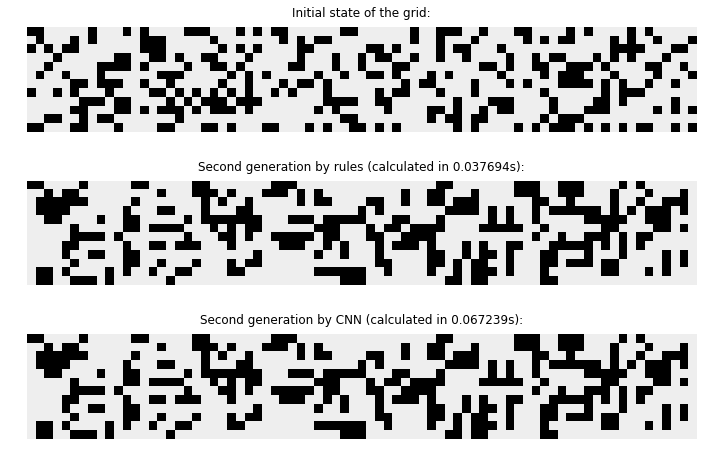

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# define the extent of the 
grid_extent = [0, width, 0, height]
color_map = ListedColormap(['#EEEEEE', '#000000'])

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,8))

for i, tg in enumerate(grids):
    title, grid = tg
    ax[i].matshow(grid, cmap=color_map, extent=grid_extent)
    ax[i].set_title(title)
    ax[i].set_axis_off()

plt.show()